# Develop `wave_height_period` Figure Module

Development of functions for `nowcast.figures.wwatch3.wave_height_period` web site figure module.

In [1]:
from pathlib import Path
from types import SimpleNamespace

import matplotlib.dates
import matplotlib.pyplot as plt
import requests
import xarray
from salishsea_tools.places import PLACES

from nowcast.figures import shared
import nowcast.figures.website_theme

In [2]:
%matplotlib inline

## `_get_wwatch3_fields()` Function

In [3]:
def _get_wwatch3_fields(dataset_url):
    ## TODO: This is a work-around because neither netCDF4 nor xarray are able
    ## to load the dataset directly from the URL due to an OpenDAP issue
    dataset_id = dataset_url.rsplit('/', 1)[1].split('.', 1)[0]
    wwatch3_fields_file = Path('/tmp').joinpath(dataset_id).with_suffix('.nc')
#     with wwatch3_fields_file.open('wb') as f:
#         resp = requests.get(f'{dataset_url}')
#         f.write(resp.content)
    try:
        wwatch3_fields = xarray.open_dataset(wwatch3_fields_file)
    except OSError:
        raise ValueError(f'WaveWatch3 fields dataset not found')
    return wwatch3_fields

## `_prep_plot_data()` Function

In [129]:
def _prep_plot_data(place, wwatch3_dataset_url):
    wwatch3_fields = _get_wwatch3_fields(wwatch3_dataset_url)
    wwatch3 = xarray.Dataset({
        'wave_height': wwatch3_fields.hs.sel(
            longitude=PLACES[place]['lon lat'][0]+360,
            latitude=PLACES[place]['lon lat'][1],
            method='nearest',
        ),
        'peak_freq': wwatch3_fields.fp.sel(
            longitude=PLACES[place]['lon lat'][0]+360,
            latitude=PLACES[place]['lon lat'][1],
            method='nearest',
        ),
    })
    wwatch3_period = slice(
        str(wwatch3_fields.time.values[0]), str(wwatch3_fields.time.values[-1])
    )
    obs = get_ndbc_buoy(place)
    obs = xarray.Dataset({
        'wave_height': obs.loc[wwatch3_period, 'WVHT [m]'],
        'dominant_period': obs.loc[wwatch3_period, 'DPD [sec]'],
    })
    # Change dataset times to Pacific time zone
    shared.localize_time(wwatch3)
    shared.localize_time(obs)
    return SimpleNamespace(
        wwatch3=wwatch3,
        obs=obs,
    )

## `_prep_fig_axes() Function`

In [5]:
def _prep_fig_axes(figsize, theme):
    fig, (ax_sig_height, ax_peak_freq) = plt.subplots(
        2, 1, figsize=figsize, facecolor=theme.COLOURS['figure']['facecolor']
    )
    fig.autofmt_xdate()
    return fig, (ax_sig_height, ax_peak_freq)


## `_plot_wave_height_time_series()` Function

In [125]:
def _plot_wave_height_time_series(ax, place, plot_data, theme):
    plot_data.obs.wave_height.plot(
        ax=ax,
        linewidth=2,
        label='ECCC Observed',
        color=theme.COLOURS['time series']['obs wave height'],
    )
    plot_data.wwatch3.wave_height.plot(
        ax=ax,
        linewidth=2,
        label='WaveWatch3',
        color=theme.COLOURS['time series']['wave height'],
    )
    legend = ax.legend(prop=theme.FONTS['legend label small'])
    legend.set_title('Legend', prop=theme.FONTS['legend title small'])
    _wave_height_time_series_labels(ax, place, plot_data, theme)

## `_wave_height_time_series_labels()` Function

In [126]:
def _wave_height_time_series_labels(ax, place, plot_data, theme):
    ax.set_title(
        f'Significant Wave Height at {place}',
        fontproperties=theme.FONTS['axes title'],
        color=theme.COLOURS['text']['axes title']
    )
    ax.set_ylabel(
        'Significant Wave Height [m]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax.grid(axis='both')
    theme.set_axis_colors(ax)

## `_plot_dominant_period_time_series()` Function

In [127]:
def _plot_dominant_period_time_series(ax, place, plot_data, theme):
    plot_data.obs.dominant_period.plot(
        ax=ax,
        linewidth=2,
        label='ECCC Observed',
        color=theme.COLOURS['time series']['obs wave period'],
    )
    (1/plot_data.wwatch3.peak_freq).plot(
        ax=ax,
        linewidth=2,
        label='WaveWatch3',
        color=theme.COLOURS['time series']['wave period'],
    )
    legend = ax.legend(prop=theme.FONTS['legend label small'])
    legend.set_title('Legend', prop=theme.FONTS['legend title small'])
    _dominant_period_time_series_labels(ax, place, plot_data, theme)

## `_dominant_period_time_series_labels()` Function

In [121]:
def _dominant_period_time_series_labels(ax, place, plot_data, theme):
    ax.set_title(
        f'Dominant Wave Period at {place}',
        fontproperties=theme.FONTS['axes title'],
        color=theme.COLOURS['text']['axes title']
    )
    ax.set_xlabel(
        f'Time [{plot_data.wwatch3.attrs["tz_name"]}]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d%b %H:%M'))
    ax.set_ylabel(
        'Dominant Wave Period [s]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax.grid(axis='both')
    theme.set_axis_colors(ax)

## `make_figure()` Function

This is is the function that will be called by the `nowcast.workers.make_plots` worker to return a `matplotlib.figure.Figure` object.

In [114]:
def make_figure(
    place,
    wwatch3_dataset_url,
    figsize=(16, 9),
    theme=nowcast.figures.website_theme,
):
    plot_data = _prep_plot_data(place, wwatch3_dataset_url)
    fig, (ax_sig_height, ax_peak_freq) = _prep_fig_axes(figsize, theme)
    _plot_wave_height_time_series(
        ax_sig_height, place, plot_data, theme
    )
    _plot_dominant_period_time_series(ax_peak_freq, place, plot_data, theme)
    return fig

## Render the Figure

The `%%timeit` cell magic lets us keep an eye on how log the figure takes to process.
Setting `-n1 -r1` prevents it from processing the figure more than once
as it might try to do to generate better statistics.

2.79 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


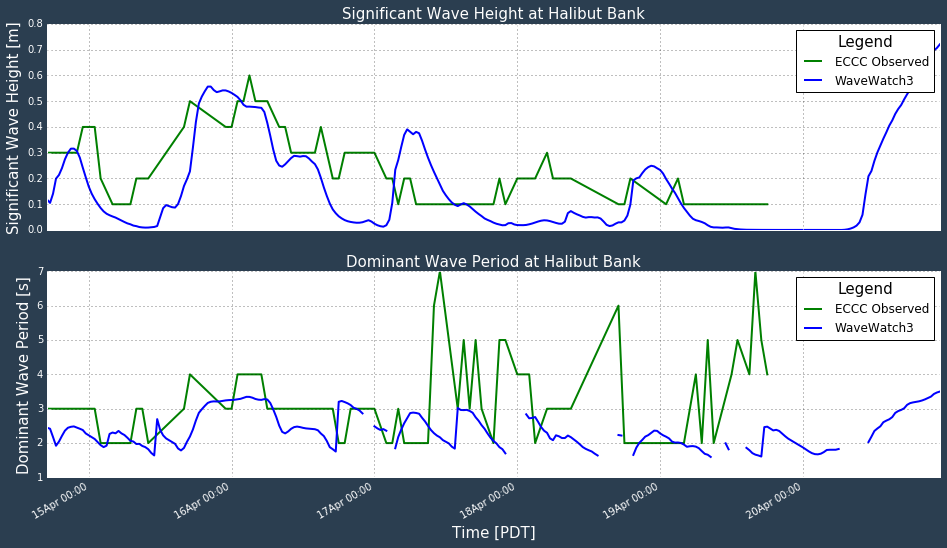

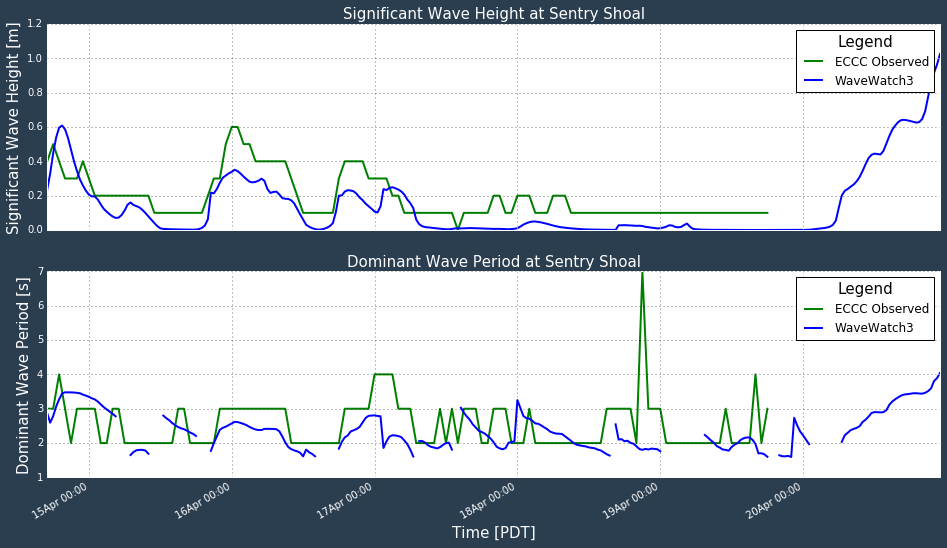

In [130]:
%%timeit -n1 -r1

from importlib import reload
from nowcast.figures import website_theme
from salishsea_tools import places
reload(website_theme)
reload(places)

wwatch3_dataset_url = (
    'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSf2DWaveFields30mV17-02.nc?hs,fp'
)

fig = make_figure('Halibut Bank', wwatch3_dataset_url)
fig = make_figure('Sentry Shoal', wwatch3_dataset_url)

In [97]:
import pandas

def get_ndbc_buoy(place):
    ndbc_url_tmpl = 'http://www.ndbc.noaa.gov/data/realtime2/{buoy_number}.txt'
    ndbc_url = ndbc_url_tmpl.format(buoy_number=PLACES[place]['EC buoy number'])

    def datetime_parser(yr, mo, dy, hr, mn):
        return datetime.strptime(f'{yr} {mo} {dy} {hr} {mn}', '%Y %m %d %H %M')

    df = pandas.read_table(
        ndbc_url, delim_whitespace=True, header=[0, 1], na_values='MM',
        parse_dates=[[0, 1, 2, 3, 4]], date_parser=datetime_parser,
    )
    columns = {"('#YY', '#yr')_('MM', 'mo')_('DD', 'dy')_('hh', 'hr')_('mm', 'mn')": 'time'}
    columns.update({t: f'{t[0]} [{t[1]}]' for t in df.columns[1:]})
    df = df.rename(index=str, columns=columns).set_index('time').sort_index()
    return df

In [98]:
df = get_ndbc_buoy('Halibut Bank')
df

,WDIR [degT],WSPD [m/s],GST [m/s],WVHT [m],DPD [sec],APD [sec],MWD [degT],PRES [hPa],ATMP [degC],WTMP [degC],DEWP [degC],VIS [nmi],PTDY [hPa],TIDE [ft]
time,,,,,,,,,,,,,,
2018-03-05 00:00:00,130,5.0,6.0,0.4,3.0,NaN,NaN,1022.2,6.3,6.9,NaN,NaN,0.8,NaN
2018-03-05 01:00:00,120,4.0,5.0,0.4,3.0,NaN,NaN,1022.6,6.3,6.9,NaN,NaN,0.7,NaN
2018-03-05 03:00:00,110,2.0,3.0,0.2,3.0,NaN,NaN,1023.4,6.4,7.1,NaN,NaN,1.2,NaN
2018-03-05 04:00:00,110,2.0,3.0,0.2,2.0,NaN,NaN,1023.8,6.6,7.0,NaN,NaN,1.2,NaN
2018-03-05 05:00:00,40,2.0,2.0,0.2,6.0,NaN,NaN,1024.2,5.8,7.2,NaN,NaN,NaN,NaN
2018-03-05 07:00:00,350,5.0,6.0,0.2,2.0,NaN,NaN,1025.1,5.4,7.2,NaN,NaN,1.3,NaN
2018-03-05 08:00:00,30,2.0,3.0,0.1,6.0,NaN,NaN,1025.6,5.3,7.1,NaN,NaN,1.4,NaN
2018-03-05 09:00:00,30,2.0,2.0,0.1,2.0,NaN,NaN,1025.9,5.3,7.0,NaN,NaN,1.2,NaN
2018-03-05 10:00:00,20,2.0,3.0,0.1,2.0,NaN,NaN,1026.3,4.9,6.9,NaN,NaN,1.2,NaN


In [100]:
ds = xarray.Dataset({
    'wave_height': df.loc['2018-04-18':'2018-04-19', 'WVHT [m]']
})
ds

<xarray.Dataset>
Dimensions:      (time: 26)
Coordinates:
  * time         (time) datetime64[ns] 2018-04-18 2018-04-18T01:00:00 ...
Data variables:
    wave_height  (time) float64 0.1 0.1 0.1 0.2 0.1 0.2 0.2 0.2 0.3 0.2 0.2 ...

In [101]:
shared.localize_time(ds)
ds

<xarray.Dataset>
Dimensions:      (time: 26)
Coordinates:
  * time         (time) datetime64[ns] 2018-04-17T17:00:00 ...
Data variables:
    wave_height  (time) float64 0.1 0.1 0.1 0.2 0.1 0.2 0.2 0.2 0.3 0.2 0.2 ...
Attributes:
    tz_name:  PDT

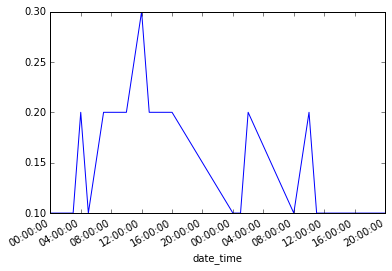

In [88]:
df.loc['2018-04-18':'2018-04-19', 'WVHT [m]'].plot()

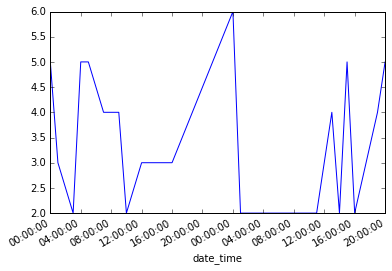

In [89]:
df.loc['2018-04-18':'2018-04-19', 'DPD [sec]'].plot()

In [13]:
wwatch3_fields = xarray.open_dataset('/tmp/ubcSSf2DWaveFields30mV17-02.nc')
wwatch3_fields

<xarray.Dataset>
Dimensions:    (latitude: 661, longitude: 572, time: 301)
Coordinates:
  * time       (time) datetime64[ns] 2018-04-15 2018-04-15T00:30:00 ...
  * latitude   (latitude) float32 48.0 48.0045 48.009 48.0135 48.018 48.0225 ...
  * longitude  (longitude) float32 234.0 234.007 234.014 234.021 234.028 ...
Data variables:
    hs         (time, latitude, longitude) float32 ...
    fp         (time, latitude, longitude) float32 ...
Attributes:
    acknowledgement:               MEOPAR, ONC, Compute Canada
    area:                          SoG_BCgrid_00500m
    cdm_data_type:                 Grid
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    creator_email:                 gemmrich@uvic.ca
    creator_name:                  Salish Sea MEOPAR Project Contributors
    creator_url:                   https://salishsea-meopar-docs.readthedocs.io/
    drawLandMask:                  over
    Easternmost_Easting:           237.997
    geospatial_lat_max:            50.

In [14]:
wwatch3_fields.hs

<xarray.DataArray 'hs' (time: 301, latitude: 661, longitude: 572)>
[113805692 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2018-04-15 2018-04-15T00:30:00 ...
  * latitude   (latitude) float32 48.0 48.0045 48.009 48.0135 48.018 48.0225 ...
  * longitude  (longitude) float32 234.0 234.007 234.014 234.021 234.028 ...
Attributes:
    colorBarMaximum:  10.0
    colorBarMinimum:  0.0
    globwave_name:    significant_wave_height
    long_name:        significant height of wind and swell waves
    standard_name:    sea_surface_wave_significant_height
    units:            m
    valid_max:        32000.0
    valid_min:        0.0

In [15]:
PLACES['Halibut Bank']

{'EC buoy number': 46146,
 'GEM2.5 grid ji': (149, 141),
 'NEMO grid ji': (503, 261),
 'lon lat': (-123.72, 49.34)}

In [16]:
hs = wwatch3_fields.hs.sel(
    longitude=PLACES['Halibut Bank']['lon lat'][0]+360,
    latitude=PLACES['Halibut Bank']['lon lat'][1],
    method='nearest',
)
hs

<xarray.DataArray 'hs' (time: 301)>
array([ 0.118116,  0.105357,  0.1409  , ...,  0.696755,  0.706446,  0.720617], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2018-04-15 2018-04-15T00:30:00 ...
    latitude   float32 49.341
    longitude  float32 236.282
Attributes:
    colorBarMaximum:  10.0
    colorBarMinimum:  0.0
    globwave_name:    significant_wave_height
    long_name:        significant height of wind and swell waves
    standard_name:    sea_surface_wave_significant_height
    units:            m
    valid_max:        32000.0
    valid_min:        0.0

In [17]:
shared.localize_time(hs)
hs

<xarray.DataArray 'hs' (time: 301)>
array([ 0.118116,  0.105357,  0.1409  , ...,  0.696755,  0.706446,  0.720617], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2018-04-14T17:00:00 2018-04-14T17:30:00 ...
    latitude   float32 49.341
    longitude  float32 236.282
Attributes:
    colorBarMaximum:  10.0
    colorBarMinimum:  0.0
    globwave_name:    significant_wave_height
    long_name:        significant height of wind and swell waves
    standard_name:    sea_surface_wave_significant_height
    units:            m
    valid_max:        32000.0
    valid_min:        0.0
    tz_name:          PDT

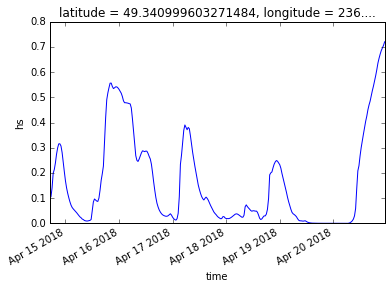

In [18]:
hs.plot()

In [19]:
fp = wwatch3_fields.fp.sel(
    longitude=PLACES['Halibut Bank']['lon lat'][0]+360,
    latitude=PLACES['Halibut Bank']['lon lat'][1],
    method='nearest',
)
fp

<xarray.DataArray 'fp' (time: 301)>
array([ 0.40878 ,  0.41364 ,  0.459781, ...,  0.291591,  0.28801 ,  0.285728], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2018-04-15 2018-04-15T00:30:00 ...
    latitude   float32 49.341
    longitude  float32 236.282
Attributes:
    colorBarMaximum:  15000.0
    colorBarMinimum:  0.0
    globwave_name:    dominant_wave_frequency
    long_name:        wave peak frequency
    standard_name:    sea_surface_wave_peak_frequency
    units:            s-1
    valid_max:        10000.0
    valid_min:        0.0

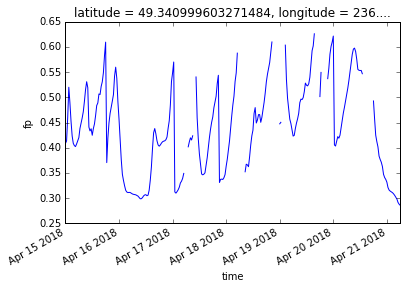

In [20]:
fp.plot()

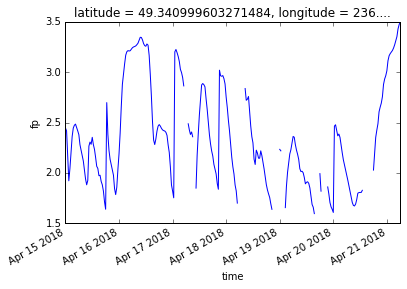

In [21]:
(1/fp).plot()